<a href="https://colab.research.google.com/github/YuHsin-Chen1221/Medical-Diagnosis-Models/blob/main/TeethSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Kaggle_API/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d takeoff1234/adult-teeth-segmenatation-dataset

Dataset URL: https://www.kaggle.com/datasets/takeoff1234/adult-teeth-segmenatation-dataset
License(s): unknown
 98% 1.52G/1.55G [00:02<00:00, 331MB/s]
100% 1.55G/1.55G [00:02<00:00, 665MB/s]


In [ ]:
!unzip /content/adult-teeth-segmenatation-dataset.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/masks_supplementary/img/cate4-00057.png  
  inflating: Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/masks_supplementary/img/cate4-00058.png  
  inflating: Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/masks_supplementary/img/cate4-00059.png  
  inflating: Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/masks_supplementary/img/cate4-00060.png  
  inflating: Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/masks_supplementary/img/cate4-00061.png  
  inflating: Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/masks_supplementary/img/cate4-00062.png  
  inflating: Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/masks_supplementary/img/cate4-00063.png  
  inflating: Dental_dataset/Adult tooth segmentation dataset/Dataset and code/test/masks_supplementary/i

# Task
Load and preprocess the image segmentation dataset located at "/content/Dental_dataset/Adult tooth segmentation dataset/Panoramic radiography database" using MONAI.

## Install monai

### Subtask:
Install the MONAI library and its dependencies.


**Reasoning**:
Install the required libraries for MONAI and image processing.



In [ ]:
!pip install monai[itk]
!pip install nibabel
!pip install scikit-image
!pip install Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.6/766.6 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os, glob
from sklearn.model_selection import train_test_split

# Base directory for dataset
base_dir = "/content/Dental_dataset/Adult tooth segmentation dataset/Archive"

image_dir = os.path.join(base_dir, "images")
mask_dir = os.path.join(base_dir, "mask")

# Collect all image paths (assuming same filenames for images and masks)
image_files = sorted(glob.glob(os.path.join(image_dir, "*.png")))
mask_files  = sorted(glob.glob(os.path.join(mask_dir, "*.png")))

# Pair them into a list of dicts
data = [{"image": img, "label": msk} for img, msk in zip(image_files, mask_files)]

# Train/val split
train_files, val_files = train_test_split(data, test_size=0.2, random_state=42)

print(f"Total: {len(data)}, Train: {len(train_files)}, Val: {len(val_files)}")


Total: 116, Train: 92, Val: 24


In [ ]:
from monai.transforms import (
    LoadImaged, EnsureChannelFirstd, ScaleIntensityd,
    ToTensord, Compose, Lambdad, Resized, EnsureTyped
)
from monai.networks.nets import UNet
from monai.losses import DiceCELoss # Import DiceCELoss
from monai.metrics import DiceMetric
from torch.optim import Adam # Import Adam optimizer
from monai.inferers import sliding_window_inference # Import sliding_window_inference
import torch
import numpy as np
from monai.data import CacheDataset, DataLoader
import os # Import os
# Remove the import of Accuracy: from monai.metrics import Accuracy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys=["image"]),
    Lambdad(keys="image", func=lambda x: x.mean(dim=0, keepdim=True)), # Convert to grayscale by averaging channels
    Resized(keys=["image", "label"], spatial_size=(256,256), mode=("bilinear","nearest")),
    Lambdad(keys="label", func=lambda x: (x > 0).astype(x.dtype)),  # binary mask
    EnsureTyped(keys=["image", "label"]),
    ToTensord(keys=["image", "label"]) # Add ToTensord here
])

val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys=["image"]),
    Lambdad(keys="image", func=lambda x: x.mean(dim=0, keepdim=True)), # Convert to grayscale by averaging channels
    Resized(keys=["image", "label"], spatial_size=(256,256), mode=("bilinear","nearest")),
    Lambdad(keys="label", func=lambda x: (x > 0).astype(x.dtype)),
    EnsureTyped(keys=["image", "label"]),
    ToTensord(keys=["image", "label"]) # Add ToTensord here
])

train_ds = CacheDataset(data=train_files, transform=train_transforms)
val_ds   = CacheDataset(data=val_files,   transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=2)

batch = next(iter(train_loader))
print("Image shape:", batch["image"].shape)
print("Label unique:", torch.unique(batch["label"]))

# =====================
# 6. Model
# =====================
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=2,   # background + teeth
    channels=(16,32,64,128,256),
    strides=(2,2,2,2),
    num_res_units=2,
).to(device)

# =====================
# 7. Loss, Optimizer, Metric
# =====================
loss_fn = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = Adam(model.parameters(), lr=1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")
# Remove the initialization of Accuracy metric: accuracy_metric = Accuracy(include_background=False, reduction="mean")

# =====================
# 8. Training Loop
# =====================

# Set CUDA_LAUNCH_BLOCKING for better error reporting (optional, remove after debugging)
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

max_epochs = 50 # Set max epochs to 50
val_interval = 1

# Early stopping parameters
patience = 10 # Number of epochs to wait for improvement
min_delta = 0.001 # Minimum change to be considered an improvement
best_val_metric = -float('inf') # Track the best validation metric (Dice score)
epochs_no_improve = 0 # Count epochs with no improvement

for epoch in range(max_epochs):
    print("-"*10, f"Epoch {epoch+1}/{max_epochs}", "-"*10)
    model.train()
    epoch_loss = 0
    epoch_correct_pixels = 0 # Initialize for accuracy calculation
    epoch_total_pixels = 0   # Initialize for accuracy calculation
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels.long()) # Cast labels to long for DiceCELoss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # Calculate accuracy during training (manual)
        outputs_argmax = torch.argmax(outputs, dim=1) # Get predicted class (remove keepdim=True)
        # Ensure labels are same shape as predictions after argmax (remove channel dim from labels)
        labels_flat = labels.long().squeeze(1) # Remove channel dim and ensure long type

        epoch_correct_pixels += (outputs_argmax == labels_flat).sum().item()
        epoch_total_pixels += labels_flat.numel()


    epoch_loss /= len(train_loader)
    epoch_acc = epoch_correct_pixels / epoch_total_pixels if epoch_total_pixels > 0 else 0 # Calculate average accuracy

    # Validation
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            dice_vals = []
            val_correct_pixels = 0 # Initialize for validation accuracy
            val_total_pixels = 0   # Initialize for validation accuracy
            for val_data in val_loader:
                val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)
                val_outputs = sliding_window_inference(val_inputs, (256,256), 2, model)
                dice_metric(y_pred=val_outputs, y=val_labels.long()) # Cast labels to long for DiceMetric

                # Calculate accuracy during validation (manual)
                val_outputs_argmax = torch.argmax(val_outputs, dim=1) # Get predicted class (remove keepdim=True)
                 # Ensure labels are same shape as predictions after argmax (remove channel dim from labels)
                val_labels_flat = val_labels.long().squeeze(1) # Remove channel dim and ensure long type

                val_correct_pixels += (val_outputs_argmax == val_labels_flat).sum().item()
                val_total_pixels += val_labels_flat.numel()


            mean_dice = dice_metric.aggregate().item()
            dice_metric.reset()
            mean_val_acc = val_correct_pixels / val_total_pixels if val_total_pixels > 0 else 0 # Calculate average validation accuracy
            print(f"Train loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Validation Dice: {mean_dice:.4f}, Validation Acc: {mean_val_acc:.4f}")

            # Early stopping check (using Dice score)
            if mean_dice > best_val_metric + min_delta:
                best_val_metric = mean_dice
                epochs_no_improve = 0
                # Optional: Save the best model state here
                # torch.save(model.state_dict(), 'best_model.pth')
            else:
                epochs_no_improve += 0.3
                if epochs_no_improve >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break # Stop training

Loading dataset: 100%|██████████| 24/24 [00:02<00:00,  9.42it/s]


Image shape: torch.Size([4, 1, 256, 256])
Label unique: metatensor([0., 1.])
---------- Epoch 1/50 ----------
Train loss: 1.1712, Train Acc: 0.6553, Validation Dice: 0.2921, Validation Acc: 0.7596
---------- Epoch 2/50 ----------
Train loss: 0.9908, Train Acc: 0.8047, Validation Dice: 0.2921, Validation Acc: 0.8534
---------- Epoch 3/50 ----------
Train loss: 0.9124, Train Acc: 0.8577, Validation Dice: 0.2921, Validation Acc: 0.8727
---------- Epoch 4/50 ----------
Train loss: 0.8659, Train Acc: 0.8737, Validation Dice: 0.2921, Validation Acc: 0.8815
---------- Epoch 5/50 ----------
Train loss: 0.8314, Train Acc: 0.8841, Validation Dice: 0.2921, Validation Acc: 0.8908
---------- Epoch 6/50 ----------
Train loss: 0.7993, Train Acc: 0.8942, Validation Dice: 0.2921, Validation Acc: 0.8983
---------- Epoch 7/50 ----------
Train loss: 0.7713, Train Acc: 0.9035, Validation Dice: 0.2921, Validation Acc: 0.9111
---------- Epoch 8/50 ----------
Train loss: 0.7457, Train Acc: 0.9120, Validation 

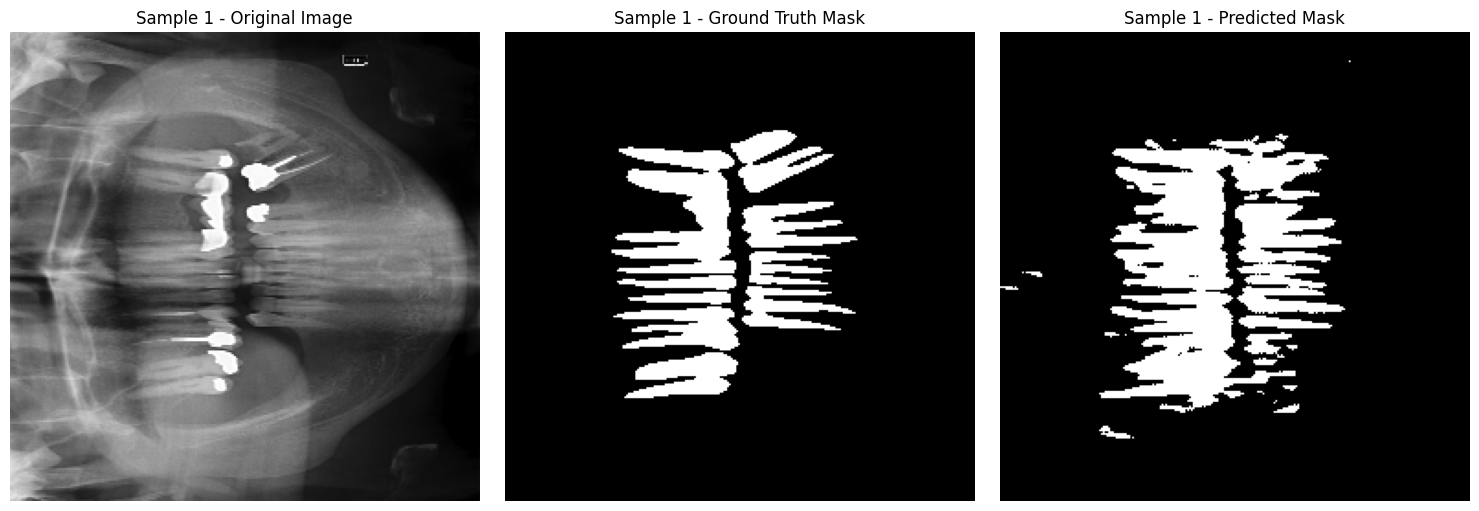

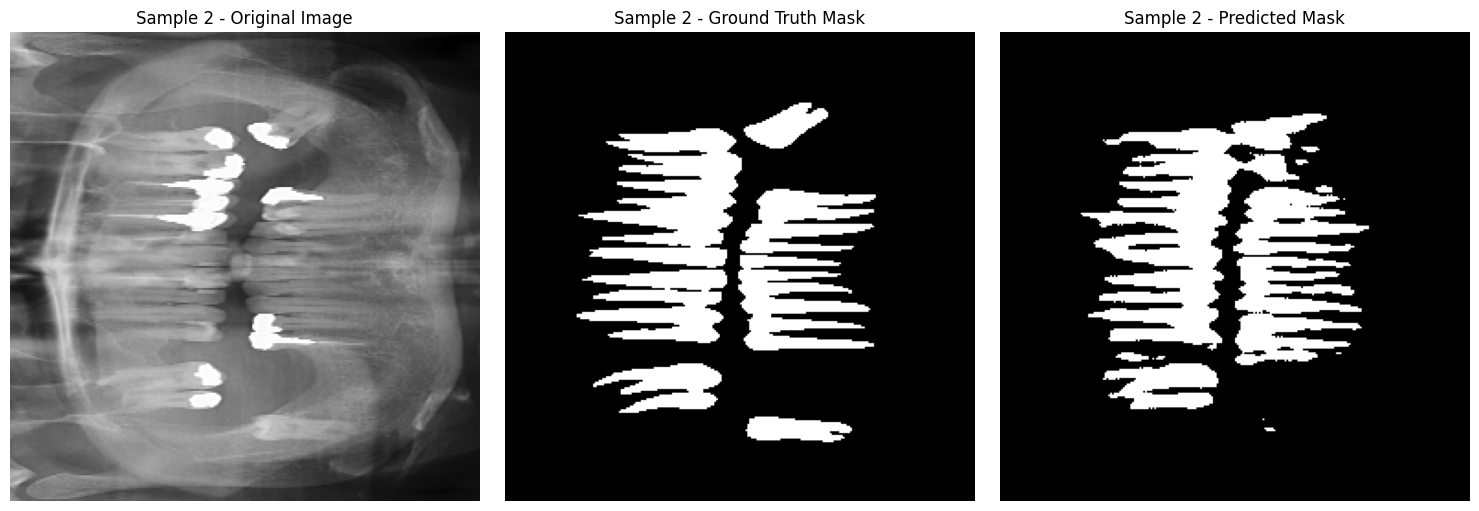

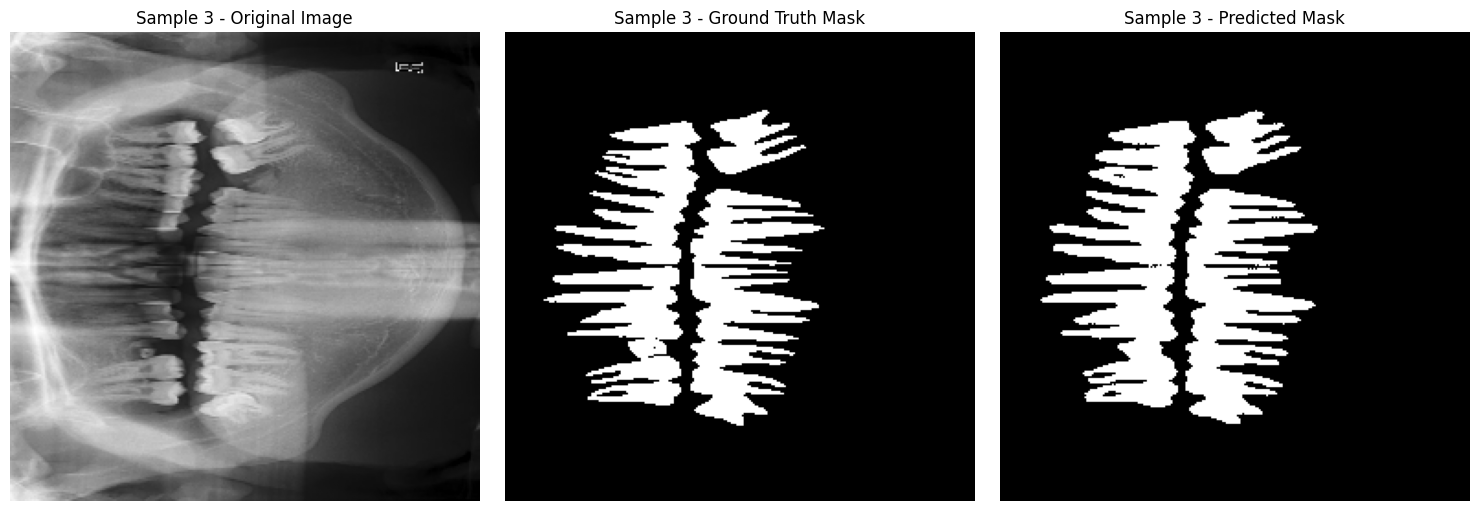

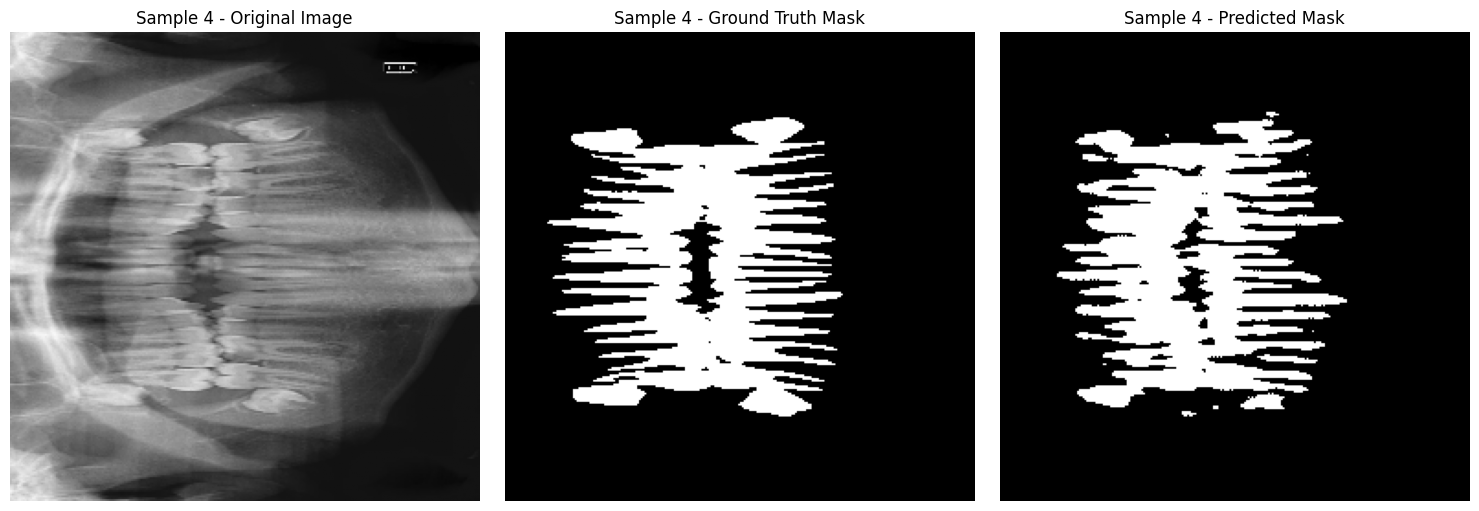

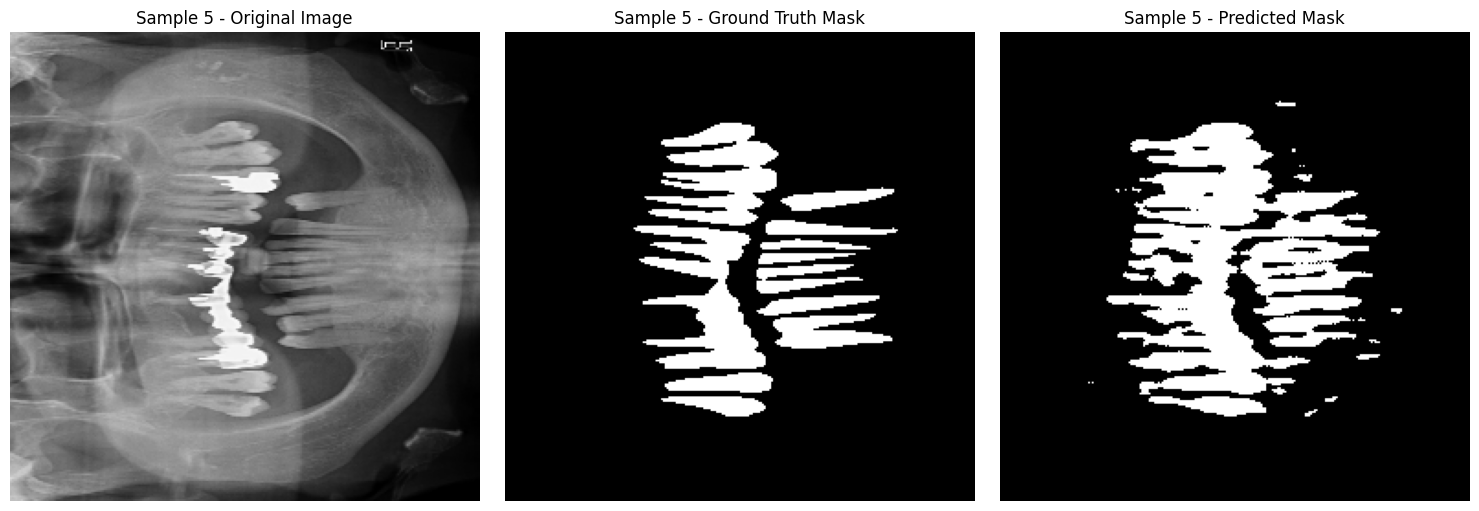

In [ ]:
import matplotlib.pyplot as plt
import torch

# Get 5 sample data points from the validation dataset
sample_indices = list(range(5))
samples_to_visualize = [val_ds[i] for i in sample_indices]

# Move model to evaluation mode
model.eval()

# Disable gradient calculation
with torch.no_grad():
    for i, sample in enumerate(samples_to_visualize):
        # Add batch dimension and move to device
        image = sample["image"].unsqueeze(0).to(device)
        label = sample["label"].unsqueeze(0).to(device)

        # Get prediction
        # Use sliding window inference if the input size is different from training
        # val_outputs = sliding_window_inference(image, (256,256), 2, model) # Uncomment and adjust if needed
        # Otherwise, a direct forward pass is sufficient
        prediction = model(image)

        # Get the predicted mask by taking the argmax along the channel dimension
        predicted_mask = torch.argmax(prediction, dim=1).squeeze(0)

        # Move tensors back to CPU for visualization
        image = image.squeeze(0).cpu()
        label = label.squeeze(0).cpu()
        predicted_mask = predicted_mask.cpu()

        # Plotting
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Original Image
        axes[0].imshow(image.permute(1, 2, 0).squeeze(), cmap='gray')
        axes[0].set_title(f"Sample {i+1} - Original Image")
        axes[0].axis('off')

        # Ground Truth Mask
        axes[1].imshow(label.permute(1, 2, 0).squeeze(), cmap='gray')
        axes[1].set_title(f"Sample {i+1} - Ground Truth Mask")
        axes[1].axis('off')

        # Predicted Mask
        axes[2].imshow(predicted_mask.squeeze(), cmap='gray')
        axes[2].set_title(f"Sample {i+1} - Predicted Mask")
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()